In [1]:
import pandas as pd
import numpy as np
import re
import json
import csv
import threading
import os
import pickle

import yfinance as yf
import yahoofinancials

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

## Sentiment Analysis

Note: the `extract_buy_or_sell` algorithm is heavily leveraged from https://github.com/theriley106/TheWSBIndex

In [3]:
def isTicker(stringVal):
    IS_TICKER = re.compile("[A-Z]{1,4}|\d{1,3}(?=\.)|\d{4,}")
    if IS_TICKER.match(stringVal):
        return stringVal in set(tickers.values)
    return False

def extract_buy_or_sell(string):
    info = {'puts': [], 'calls': [], 'buy': [], 'sell': []}
    # Extracts the words buy or sell from the comment
    for val in re.split("(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s", string):
        # This splits the string into sentences
        allWords = re.findall("\w+", str(val))
        while len(allWords) > 0:
            word = allWords.pop(0)
            if re.match("[\W]?([Bb]uy)[\W]?", word):
                # This means it's the word buy
                tempList = []
                while len(allWords) > 0:
                    newWord = allWords.pop(0)
                    if isTicker(newWord):
                        tempList.append(newWord)
                    elif re.match("[\W]?([Pp]ut[s]?)[\W]?", newWord):
                        if len(tempList) > 0:
                            # This means a sentence like
                            # put $5 in TSLA
                            while len(tempList) > 0:
                                info['puts'].append(tempList.pop())
                            break

                    elif re.match("[\W]?([Cc]all[s]?)[\W]?", newWord):
                        if len(tempList) > 0:
                            # This means a sentence like
                            # call my friend to put $5 in TSLA
                            while len(tempList) > 0:
                                info['calls'].append(tempList.pop())
                            break
                info['buy'] += tempList

            elif re.match("[\W]?[Ss]horting?[\W]?", word):
                while len(allWords) > 0:
                    newWord = allWords.pop(0)
                    if isTicker(newWord):
                        info['sell'].append(newWord)
                    else:
                        break

            elif re.match("[\W]?([Ss]ell|[Ss]old|[Cc]los[(e|ing)]|[Ss]hort[s]?)[\W]?", word):
                # This means it's indicating they want to sell
                # Sell TSLA puts would be equivilant to a call
                tempList = []
                while len(allWords) > 0:
                    newWord = allWords.pop(0)
                    if isTicker(newWord):
                        tempList.append(newWord)
                    elif re.match("[\W]?([Pp]ut[s]?)[\W]?", newWord):
                        if len(tempList) > 0:
                            # This means a sentence like
                            # put $5 in TSLA
                            while len(tempList) > 0:
                                info['calls'].append(tempList.pop())
                            break

                    elif re.match("[\W]?([Cc]all[s]?)[\W]?", newWord):
                        if len(tempList) > 0:
                            # This means a sentence like
                            # call my friend to put $5 in TSLA
                            while len(tempList) > 0:
                                info['puts'].append(tempList.pop())
                            break

                    elif re.match("[Ss]hort[s]?", newWord):
                        # IE closing out a short == buy
                        if len(tempList) > 0:
                            # This means a sentence like
                            # call my friend to put $5 in TSLA
                            while len(tempList) > 0:
                                info['buy'].append(tempList.pop())
                            break

                info['sell'] += tempList

            elif isTicker(word):
                tempList = [word]
                while len(allWords) > 0:
                    newWord = allWords.pop(0)
                    if isTicker(newWord):
                        tempList.append(newWord)
                    elif re.match("[\W]?([Pp]ut[s]?)[\W]?", newWord):
                        if len(tempList) > 0:
                            # This means a sentence like
                            # put $5 in TSLA
                            while len(tempList) > 0:
                                info['puts'].append(tempList.pop())
                            break

                    elif re.match("[\W]?([Cc]all[s]?)[\W]?", newWord):
                        if len(tempList) > 0:
                            # This means a sentence like
                            # call my friend to put $5 in TSLA
                            while len(tempList) > 0:
                                info['calls'].append(tempList.pop())
                            break
                info['buy'] += tempList
    # Remove duplicates from lists
    for key, val in info.items():
        temp_list = list(dict.fromkeys(info[key]))
        info[key] = temp_list
    return info

In [4]:
df = pickle.load(open("wsb.pkl", "rb"))

In [14]:
def min_max_date(df):
    """
    Get the min and max date of the ticker being mentioned in our WSB dataset
    """
    min_date = df.sort_values('datetime').iloc[0]["datetime"].date()
    max_date = df.sort_values('datetime', ascending= False).iloc[0]["datetime"].date()
    return(min_date, max_date)

def explode_action_column(df):
    """
    Explodes columns of
    dict(puts: [., ., .,]
         calls: [., ., .,]
         sell: [., ., .,]
         buy: [., ., .,])
         
    into four columns ...
    |puts|calls|sell|buy|
    """
    return pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)

def date_from_datetime(df):
    """
    Make datetime to date
    """
    df_copy = df.copy()
    df_copy["Date"] = df_copy["datetime"].dt.date
    return df_copy

def flatten_filter(df, ticker):
    """
    Explodes the column of lists of tickers into multiple rows and then filter for ticker
    """
    df_copy = df.copy()
    df_flatten = df_copy.explode('tickers')
    df_flatten = df_flatten[df_flatten['tickers'] == ticker]
    return df_flatten

def indicator_actions(df, ticker):
    """
    Make indicator variables for ticker instead of list of tickers
    """
    df_copy = df.copy()
    df_copy = explode_action_column(df_copy)
    df_copy["puts"] = ((df_copy["puts"].apply(len) != 0) & 
                      (df_copy["puts"].astype('str').str.contains(ticker))).astype(int)
    df_copy["calls"] = ((df_copy["calls"].apply(len) != 0) & 
                       (df_copy["calls"].astype('str').str.contains(ticker))).astype(int)
    df_copy["buy"] = ((df_copy["buy"].apply(len) != 0) & 
                     (df_copy["buy"].astype('str').str.contains(ticker))).astype(int)
    df_copy["sell"] = ((df_copy["sell"].apply(len) != 0) & 
                      (df_copy["sell"].astype('str').str.contains(ticker))).astype(int)
    return df_copy

def plot_actions(df, ticker, min_date, max_date):
    """
    Plot the aggregate sum of sell, buy, calls ,puts for each day within range for a specific ticker
    """
    df_copy = df.copy()
    
    # Aggregate financial action frequency per day
    agg_sell = df_copy[['Date','sell','buy','calls','puts']].groupby('Date').agg('sum')

    # Filter for range specified
    mask = (agg_sell.index > pd.to_datetime("2018-01-01").date()) & (agg_sell.index <= max_date)

    agg_sell.loc[mask].plot(figsize=(12, 10), linewidth=2.5)
    plt.xlabel("Date", labelpad=15)
    plt.ylabel("Movement Mentions", labelpad=15)
    plt.title("Movement mentions for {0} from {1} to {2}".format(ticker, str(min_date), str(max_date)), y=1.02, fontsize=22);

def plot_stock_vs_wsb(df,ticker, min_date, max_date, stock_col, action_col):
    """
    Plot the a specfic financial action mention in WSB comments vs historical data
    """
    df_copy = df.copy()
    
    # Aggregate financial action frequency per day
    agg_sell = df_copy[['Date','sell','buy','calls','puts','score']].groupby('Date').agg('sum')
    
    
    # Get the minimum date of that ticker mentioned on our WSB comment
    MIN_DATE, MAX_DATE = min_max_date(df)

    # Pull the data from yahoo finance api
    stock_data = yf.download(ticker, start = MIN_DATE, end = MAX_DATE)
    
    # Filter for range specified
    mask = (stock_data.index > np.datetime64(str(min_date))) & (stock_data.index <= np.datetime64(max_date))

    plot_multi(stock_data.loc[mask].join(other = agg_sell)[[stock_col,action_col]], figsize=(10,5))

    plt.xlabel("Date", labelpad=15)
    plt.ylabel("Daily {0} mentions".format(action_col), labelpad=15)
    plt.title("Daily {1} mentions vs {2} from {3} to {4} for {0}".format(ticker, action_col, stock_col, str(min_date), str(max_date)), y=1.02, fontsize=22);

In [6]:
tesla_df = date_from_datetime(flatten_filter(df, 'TSLA'))

In [7]:
min_date, max_date = min_max_date(tesla_df)

In [8]:
tesla_sent = indicator_actions(tesla_df, 'TSLA')

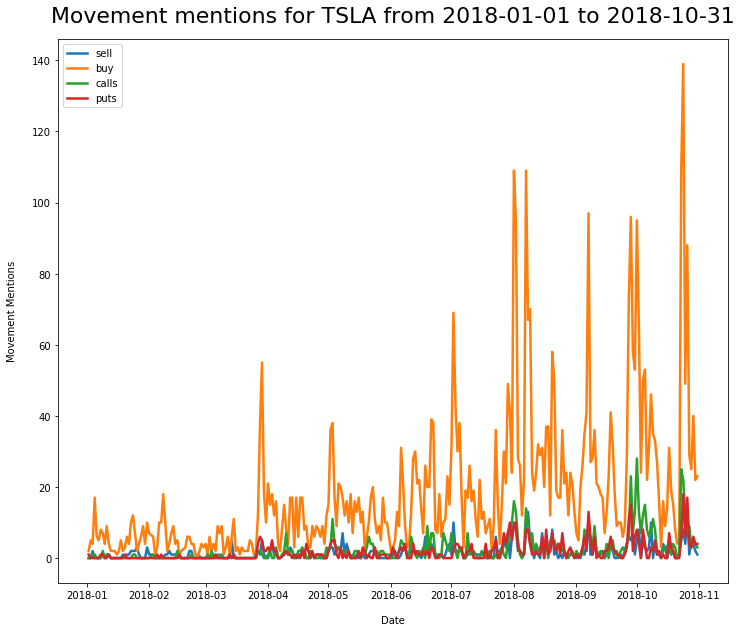

In [9]:
plot_actions(tesla_sent, 'TSLA', min_date = "2018-01-01", max_date = max_date)

[*********************100%***********************]  1 of 1 completed


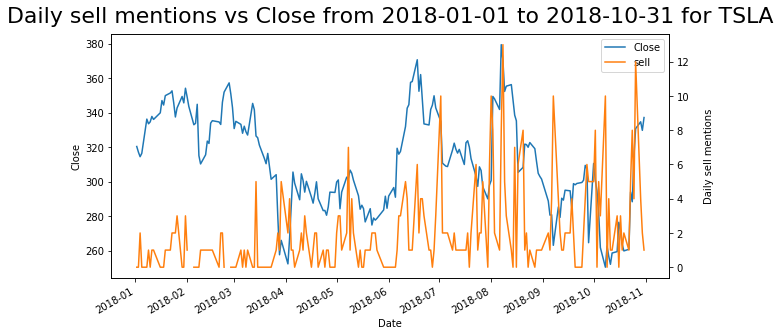

In [10]:
plot_stock_vs_wsb(tesla_sent, 'TSLA',min_date = "2018-01-01",
                  max_date = max_date, stock_col = 'Close', action_col = 'sell')

[*********************100%***********************]  1 of 1 completed


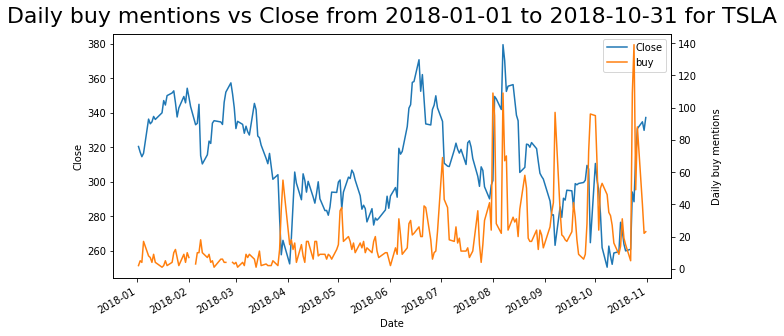

In [11]:
plot_stock_vs_wsb(tesla_sent, 'TSLA',min_date = "2018-01-01",
                  max_date = max_date, stock_col = 'Close', action_col = 'buy')

[*********************100%***********************]  1 of 1 completed


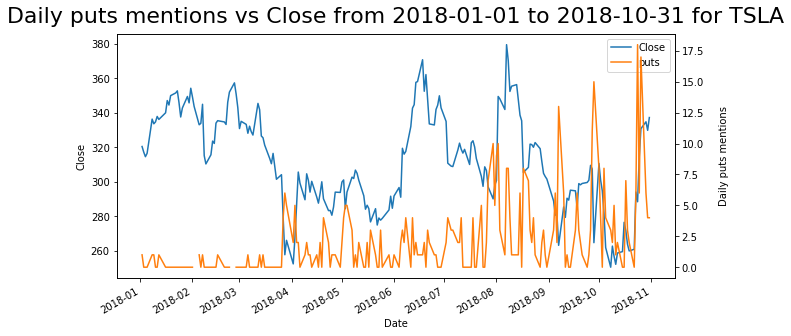

In [12]:
plot_stock_vs_wsb(tesla_sent, 'TSLA',min_date = "2018-01-01",
                  max_date = max_date, stock_col = 'Close', action_col = 'puts')

[*********************100%***********************]  1 of 1 completed


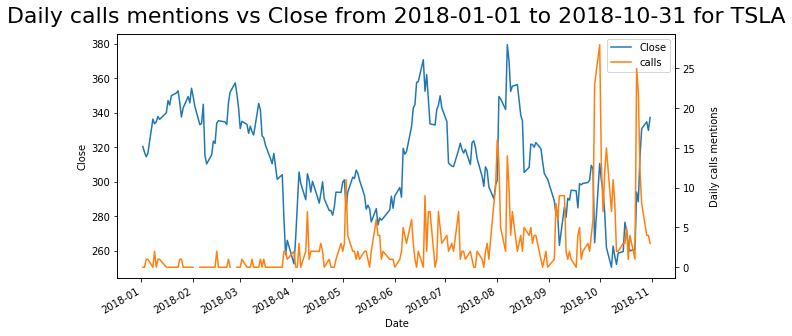

In [13]:
plot_stock_vs_wsb(tesla_sent, 'TSLA',min_date = "2018-01-01",
                  max_date = max_date, stock_col = 'Close', action_col = 'calls')

[*********************100%***********************]  1 of 1 completed


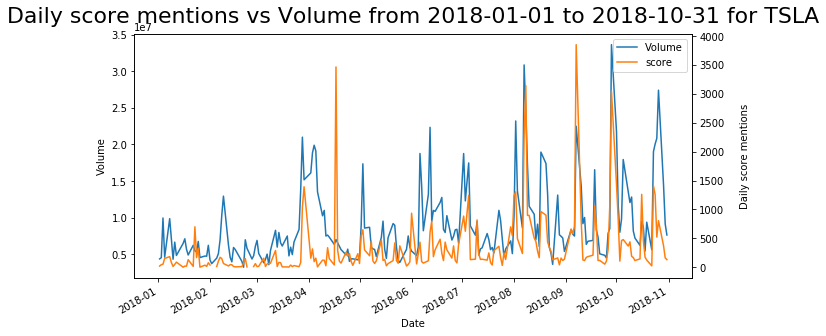

In [16]:
plot_stock_vs_wsb(tesla_sent, 'TSLA',min_date = "2018-01-01",
                  max_date = max_date, stock_col = 'Volume', action_col = 'score')